In [120]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
sns.set_style("dark")

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas_datareader.data import DataReader
import datetime as dt

# libraries for pipeline|
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA

# Gridsearch
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

#metrics
import sklearn.metrics as metrics

# Models to try
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# custom functions
from modules import functions

# Market Data Gathering

In [121]:
# Important dates
start = dt.datetime(2022,7,23)
end = dt.datetime(2022,8,14)


In [122]:
# import data
nflx = DataReader("NFLX",  "yahoo", start, end)
gspc = DataReader("^GSPC", "yahoo", start, end)

# sentiment data
tweet_sentiment = pd.read_csv('../data/tweets/classified/tweets_mean_sentiment.csv', index_col=0)
news_sentiment = pd.read_csv('../data/news/classified/news_mean_sentiment.csv', index_col=0)

# turn dates to datetime
tweet_sentiment.index = pd.to_datetime(tweet_sentiment.index)
news_sentiment.index = pd.to_datetime(news_sentiment.index)

# remove weekends, for now
tweet_sentiment = tweet_sentiment[tweet_sentiment.index.dayofweek < 5]
news_sentiment = news_sentiment[news_sentiment.index.dayofweek < 5]

# # cut data from sentiment to start and end dates
tweet_sentiment = tweet_sentiment[start:end]
news_sentiment = news_sentiment[start:end]

In [123]:
# concatenate stock and market data
features = functions.concatRename(nflx, 'nflx_', gspc, 'gspc_')

# add sentiment features
merged_features = pd.concat([features, news_sentiment['news_daily_sentiment'], tweet_sentiment['tweet_sentiment_pred']], join='outer', axis=1)

# Set-up time series prediction

Pipelines does not support dropping rows in the target data, so we must pre-process here. We take the features from the previous n days and use them to predict 

In [124]:
# target variable name
nflx_target = 'nflx_Adj Close'

# we do not drop the target variable, as we'll be shifting it
X = merged_features
y = merged_features[nflx_target]

In [125]:
# shift features and drop nans
rolling = 1
X_shifted = functions.shiftTime(X, rolling)

# find diff and drop nans
diff_delta = 1
X_diff = functions.trendDiff(X_shifted[[nflx_target]],diff_delta)

# drop rolling rows from y
y_shifted = y.iloc[rolling:]

In [126]:
# take the last 0.20% for validation
test_size=0.3

X_train, X_test = functions.testSplit(X, test_size)
y_train, y_test = functions.testSplit(y, test_size)

In [127]:
# specify feats for column transformer, those not included will be dropped
num_feats = ['nflx_Adj Close', 'nflx_High', 'nflx_Low', 'nflx_Volume', 'gspc_Adj Close', 'tweet_sentiment_pred']
cat_feats = ['news_daily_sentiment']

# Feature Engineering

In [128]:
# Feature Engineering Pipelines

num_transform = Pipeline([
    ('Imputer', KNNImputer()),
    ('scaling', StandardScaler()),
    ('select_best', SelectKBest(k=5)),
    ])

cat_transform = Pipeline([
    ('Imputer', SimpleImputer(strategy='constant', fill_value='neutral')),
    ('one_hot', OneHotEncoder(sparse=False)),
    # ('pca', PCA(n_components=3)),
    ])

In [129]:
preprocessing = ColumnTransformer([
    ('num_transform', num_transform, num_feats),
    ('cat_transform', cat_transform, cat_feats)
    ], remainder='drop')

In [130]:
pipeline = Pipeline([
    # ('initial_shift', functions.shiftTime(rolling=1)),
    # ('drop_nans', t_drop_na),
    ('preprocessing', preprocessing),
    ('regressor', LinearRegression()),
    ])

In [131]:
model = pipeline.fit(X_train, y_train)

# calculate optimized score
print('# train pred')
y_train_pred = model.predict(X_train)
functions.regression_results(y_train, y_train_pred)

print('# test pred')
y_test_pred = model.predict(X_test)
functions.regression_results(y_test, y_test_pred)

# train pred
explained_variance:  0.9711
mean_squared_log_error:  0.0
r2:  0.9711
MAE:  0.6014
MSE:  0.7512
RMSE:  0.8667
# test pred
explained_variance:  0.7033
mean_squared_log_error:  0.0003
r2:  0.6069
MAE:  3.3549
MSE:  19.9214
RMSE:  4.4633


c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)


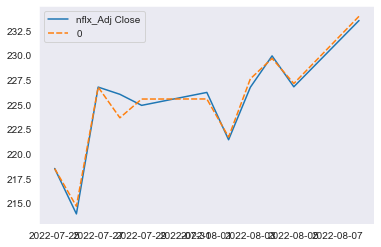

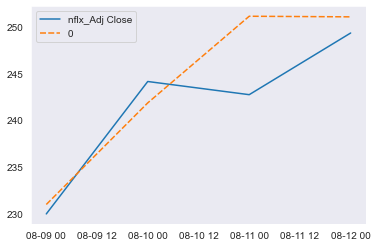

In [132]:
# plot training predictions
y_train_pred_df = pd.concat([y_train, pd.Series(y_train_pred, index=y_train.index)], axis=1)
sns.lineplot(data=y_train_pred_df)
plt.show()

# plot predictions
y_test_pred_df = pd.concat([y_test, pd.Series(y_test_pred, index=y_test.index)], axis=1)
sns.lineplot(data=y_test_pred_df)
plt.show()

# Optimization

In [133]:
# XGBoost params
xgb_params = {
    'regressor': [xgb.XGBRegressor()],
    # 'feature_engineering__num_transform_scaling': [MinMaxScaler(), StandardScaler()],
    'regressor__booster': ['gblinear'],
    'regressor__lambda': [0, 0.5, 1],
    'regressor__alpha': [0, 0.5 , 1],
}

In [134]:
# make custome scorer
rmse_score = metrics.make_scorer(functions.rmse, greater_is_better=False)

In [135]:
# instantiate gridsearch and time series CV technique
gridsearch = GridSearchCV(estimator=pipeline, param_grid=xgb_params, cv=TimeSeriesSplit(n_splits=3), scoring=rmse_score)

In [136]:
# find best model
gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
best_score = gridsearch.best_score_

c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:109: RuntimeWarning: invalid value encountered in true_divide
  msw = sswn / float(dfwn)
c:\Users\lapen\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_sele

In [137]:
# calculate optimized score
print('# train pred')
y_train_pred = best_model.predict(X_train)
functions.regression_results(y_train, y_train_pred)

print('# test pred')
y_test_pred = best_model.predict(X_test)
functions.regression_results(y_test, y_test_pred)

# train pred
explained_variance:  0.8084
mean_squared_log_error:  0.0001
r2:  0.8084
MAE:  1.9439
MSE:  4.9776
RMSE:  2.2311
# test pred
explained_variance:  0.7541
mean_squared_log_error:  0.001
r2:  -0.2017
MAE:  6.9597
MSE:  60.902
RMSE:  7.804


<AxesSubplot:>

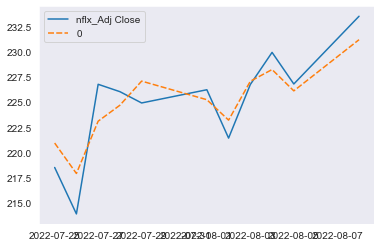

In [138]:
# plot training predictions
y_train_pred_df = pd.concat([y_train, pd.Series(y_train_pred, index=y_train.index)], axis=1)
sns.lineplot(data=y_train_pred_df)

<AxesSubplot:>

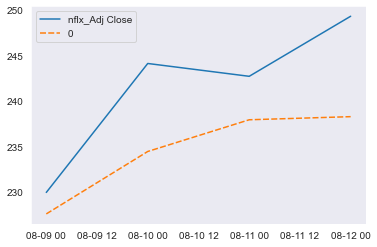

In [139]:
# plot predictions
y_test_pred_df = pd.concat([y_test, pd.Series(y_test_pred, index=y_test.index)], axis=1)
sns.lineplot(data=y_test_pred_df)